In [1]:
from src.model.encrypted_model import EncryptedDNN
from src.model.dnn import DNN, Detector
import torch
import numpy as np
import tenseal as ts
import copy
import matplotlib.pyplot as plt

In [2]:
context = ts.context(ts.SCHEME_TYPE.CKKS, 16384, coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 40, 40, 40, 40])
context.global_scale = pow(2, 40)
context.generate_galois_keys()

In [3]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()


In [4]:
x = torch.randn(64,1) 
x_enc = ts.ckks_tensor(ctx_training, x.tolist())

y_ground = torch.ones(2,1) 
y_ground[0] = 0
y_ground_enc =  ts.ckks_tensor(ctx_training, y_ground.tolist())

In [5]:
model_real = DNN(64, 2, True)
detector_real = Detector(2)
model_enc = EncryptedDNN(model_real, detector_real, 2, ctx_training)
model_enc.encrypt(ctx_training)

In [6]:
criterion = torch.nn.MSELoss(reduction="mean")

In [7]:
model_real.fc2.weight.shape

torch.Size([2, 32])

# Parameters switch

In [7]:
model_enc.target_w = model_real.fc1.weight.data.detach().cpu().tolist()
model_enc.target_b = model_real.fc1.bias.data.detach().cpu().tolist()

model_enc.detect_weight = detector_real.fc1.weight.data.detach().cpu().tolist()
model_enc.detect_bias = detector_real.fc1.bias.data.detach().cpu().tolist()

model_enc.encrypt(ctx_training)

model_enc.decrypt()

model_real.fc1.weight = torch.nn.parameter.Parameter(
            torch.tensor(model_enc.fc1_weight, device="cpu"))
model_real.fc1.bias = torch.nn.parameter.Parameter(torch.tensor(model_enc.fc1_bias, device="cpu"))
detector_real.fc1.weight = torch.nn.parameter.Parameter(
    torch.tensor(model_enc.detect_weight, device="cpu"))
detector_real.fc1.bias = torch.nn.parameter.Parameter(
    torch.tensor(model_enc.detect_bias, device="cpu"))

# Forward

In [8]:
y_pred = detector_real(model_real(x.T, True))

In [9]:
y_pred_enc = model_enc.forward_watermarking(x_enc)

In [10]:
y_pred.argmax().item()

0

In [11]:
np.array(y_pred_enc.decrypt().tolist()).argmax()

0

# Backward - fc1

In [12]:
loss = criterion(y_pred, y_ground.T)
loss.backward(retain_graph=True)

In [13]:
grad = model_real.fc1.weight.grad 
grad = grad + abs(grad.min()) 
grad = grad / grad.max()

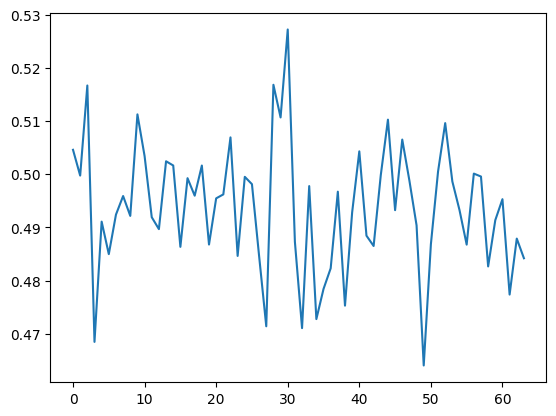

In [14]:
plt.plot(grad[14,:])

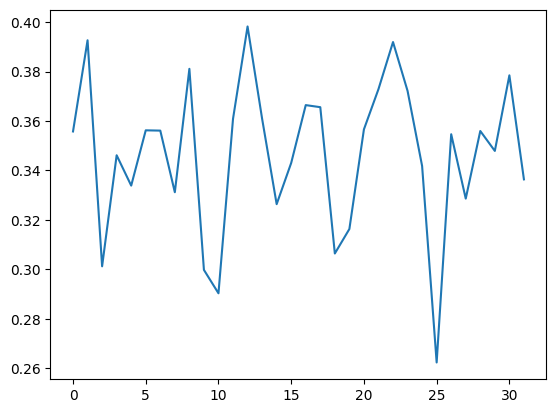

In [24]:
model_enc.refresh_all_parameters()
x_enc = model_enc.refresh(x_enc)
y_pred_enc = model_enc.refresh(y_pred_enc)
y_ground_enc = model_enc.refresh(y_ground_enc)
grad_enc = torch.tensor(model_enc.backward_fc1(x_enc, y_pred_enc, y_ground_enc)[0].decrypt().tolist())
grad_enc = grad_enc + abs(grad_enc.min()) 
grad_enc = grad_enc / grad_enc.max()
plt.plot(grad_enc[14,:])

[]

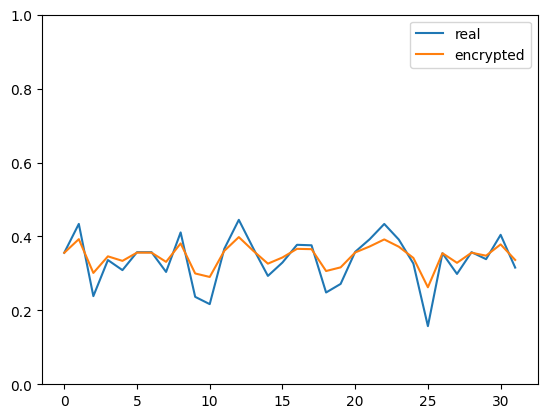

In [25]:
i = 14
plt.plot(grad[i,:], label="real")
plt.plot(grad_enc[i,:], label="encrypted")
plt.legend()
plt.ylim(0,1)
plt.plot()

In [26]:
(abs(grad-grad_enc)).max()

tensor(0.1051)

# Backward - detect

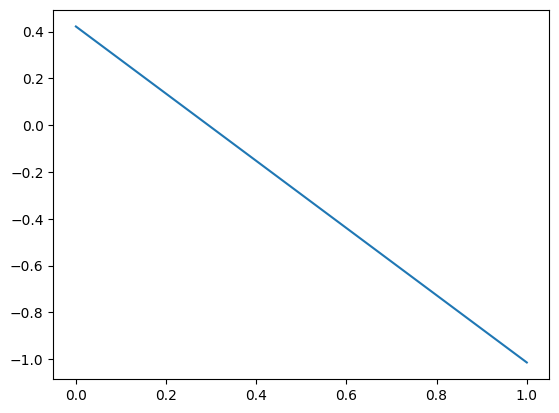

In [27]:
plt.plot(detector_real.fc2.bias.grad.numpy()[:])

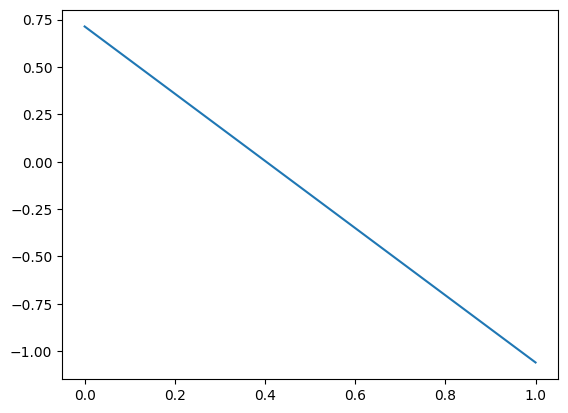

In [28]:
x_enc = model_enc.refresh(x_enc)
y_pred_enc = model_enc.refresh(y_pred_enc)
y_ground_enc = model_enc.refresh(y_ground_enc)
plt.plot(np.array(model_enc.backward(x_enc, y_pred_enc, y_ground_enc)[3].decrypt().tolist())[:])

In [29]:
grad_detect = detector_real.fc1.weight.grad
grad_detect = grad_detect + abs(grad_detect.min())
grad_detect = grad_detect / grad_detect.max()

grad_detect_enc = torch.tensor(model_enc.backward_detect(x_enc, y_pred_enc, y_ground_enc)[0].decrypt().tolist())
grad_detect_enc = grad_detect_enc + abs(grad_detect_enc.min())
grad_detect_enc = grad_detect_enc / grad_detect_enc.max()

diff_detect = abs(grad_detect - grad_detect_enc).max()

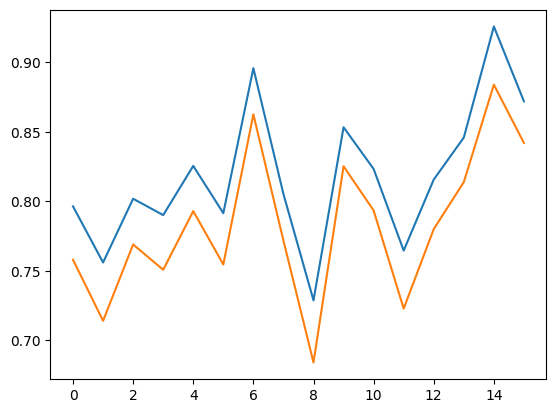

In [30]:
i = 0
plt.plot(grad_detect[i,:])
plt.plot(grad_detect_enc[i,:])

In [31]:
(grad_detect-grad_detect_enc).max()

tensor(0.0447)

In [32]:
grad_detect

tensor([[0.7964, 0.7560, 0.8019, 0.7901, 0.8255, 0.7915, 0.8959, 0.8053, 0.7287,
         0.8534, 0.8233, 0.7646, 0.8157, 0.8459, 0.9259, 0.8720],
        [0.3432, 0.1384, 0.3711, 0.3114, 0.4909, 0.3184, 0.8478, 0.3882, 0.0000,
         0.6321, 0.4798, 0.1818, 0.4411, 0.5944, 1.0000, 0.7267]])

# Bias

In [33]:
grad = model_real.fc1.bias.grad 
grad = grad + abs(grad.min()) 
grad = grad / grad.max()

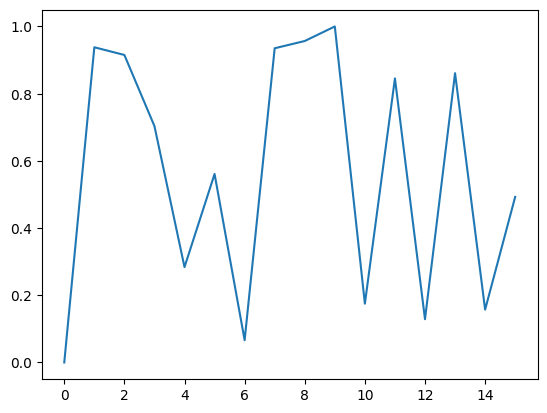

In [34]:
plt.plot(grad)

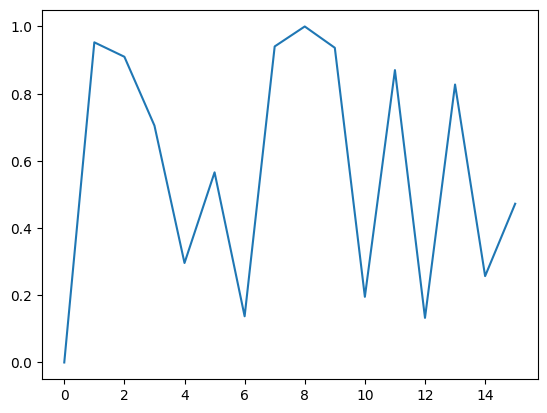

In [35]:
grad_enc = torch.tensor(model_enc.backward_fc1(x_enc, y_pred_enc, y_ground_enc)[1].decrypt().tolist())
grad_enc = grad_enc + abs(grad_enc.min()) 
grad_enc = grad_enc / grad_enc.max()
plt.plot(grad_enc[0])

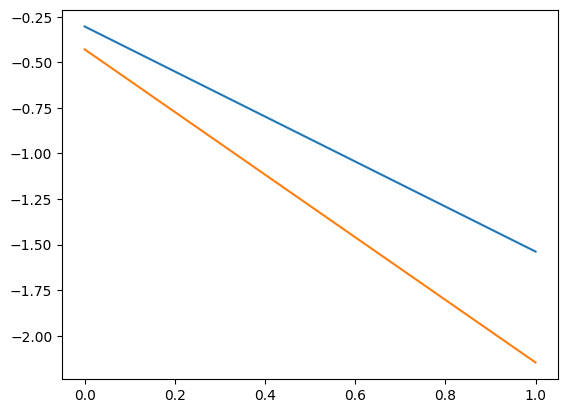

In [36]:
grad = detector_real.fc1.bias.grad
grad_enc = torch.tensor(model_enc.backward_detect(x_enc, y_pred_enc, y_ground_enc)[1].decrypt().tolist())
plt.plot(grad)
plt.plot(grad_enc)

In [37]:
grad

tensor([-0.3033, -1.5381])

In [38]:
grad_enc

tensor([[-0.4287],
        [-2.1464]])

# update

In [29]:
model_enc.update_parameters()